## TP 1

In [ ]:
import numpy as np
import scipy.stats as si
import plotly.graph_objects as go
import yfinance as yf

In [ ]:
# Récupération des données depuis Yahoo Finance
symbol = 'ADBE'  # Symbole pour Adobe
stock = yf.Ticker(symbol)
current_price = stock.history(period='1d')['Close'][0]

# Dates importantes
options = stock.options
print(f"Dates d'expiration des options disponibles : {options}")

Dates d'expiration des options disponibles : ('2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07', '2025-02-14', '2025-02-21', '2025-02-28', '2025-03-21', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15')


<ipython-input-14-211fbdadd9fe>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock.history(period='1d')['Close'][0]


### Calcul d'un call

In [ ]:
# 1. Black-Scholes Model
def black_scholes(t, S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)

    if option_type == "call":
        price = S * si.norm.cdf(d1) - K * np.exp(-r * (T-t)) * si.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * (T-t)) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    else:
        raise ValueError("Type d'option non valide")
    return price

# 2. Monte Carlo Simulation
def monte_carlo(t_, S0, K, T, r, sigma, n_simulations, n_steps, option_type="call"):
    dt = (T-t_) / n_steps
    prices = np.zeros((n_simulations, n_steps + 1))
    prices[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        prices[:, t] = prices[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    if option_type == "call":
        payoffs = np.maximum(prices[:, -1] - K, 0)
    elif option_type == "put":
        payoffs = np.maximum(K - prices[:, -1], 0)
    else:
        raise ValueError("Type d'option non valide")

    return np.exp(-r * (T-t_)) * np.mean(payoffs)

In [ ]:
# Prix avec Black-Scholes
t = 0
# Paramètres de base
S0 = 42  # Prix actuel de l'action Adobe
K = 40  # Prix d'exercice fixé à 3% au-dessus du prix actuel
T = 6/12  # Temps jusqu'à l'échéance (en années)
r = 0.1  # Taux sans risque
sigma = 0.20  # Volatilité


n_simulations = 500  # Simulations pour Monte Carlo
n_steps = 100  # Étapes pour Monte Carlo
bs_price = black_scholes(t, S0, K, T, r, sigma)
print(f"Prix Black-Scholes : {bs_price:.2f}")

# Prix avec Monte Carlo
mc_price = monte_carlo(t, S0, K, T, r, sigma, n_simulations, n_steps)
print(f"Prix Monte Carlo : {mc_price:.2f}")

Prix Black-Scholes : 4.76
Prix Monte Carlo : 4.80


In [ ]:
t = 0
# Paramètres de base
S0 = 42  # Prix actuel de l'action Adobe
K = 40  # Prix d'exercice fixé à 3% au-dessus du prix actuel
T = 3/12  # Temps jusqu'à l'échéance (en années)
r = 0.1  # Taux sans risque
sigma = 0.20  # Volatilité


n_simulations = 500  # Simulations pour Monte Carlo
n_steps = 100  # Étapes pour Monte Carlo
bs_price = black_scholes(t, S0, K, T, r, sigma)
print(f"Prix Black-Scholes : {bs_price:.2f}")

# Prix avec Monte Carlo
mc_price = monte_carlo(t, S0, K, T, r, sigma, n_simulations, n_steps)
print(f"Prix Monte Carlo : {mc_price:.2f}")

Prix Black-Scholes : 3.53
Prix Monte Carlo : 3.50


### Calcul des Greeks

In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_greeks(S, K, r, sigma, T, option_type='call'):
    """
    Calcule les Greeks Delta, Gamma et Vega en utilisant la formule de Black-Scholes.

    Paramètres :
    - S : float, prix de l'actif sous-jacent
    - K : float, prix d'exercice de l'option
    - r : float, taux d'intérêt sans risque (en décimal, par exemple 0.05 pour 5%)
    - sigma : float, volatilité du sous-jacent (en décimal, par exemple 0.2 pour 20%)
    - T : float, temps jusqu'à l'échéance (en années)
    - option_type : str, 'call' ou 'put' (par défaut 'call')

    Retour :
    - dict contenant les valeurs de Delta, Gamma et Vega
    """
    # Calcul de d1 et d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Delta
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("Le type d'option doit être 'call' ou 'put'")

    # Gamma (identique pour call et put)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    # Vega (identique pour call et put, exprimé en décimal pour une variation de 1%)
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100

    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega}


import numpy as np

def monte_carlo_greeks(S, K, r, sigma, T, num_simulations=100000, epsilon=0.01):
    """
    Calcule les Greeks (Delta, Gamma, Vega) en utilisant la simulation Monte Carlo.

    Paramètres :
    - S : float, prix de l'actif sous-jacent
    - K : float, prix d'exercice de l'option
    - r : float, taux d'intérêt sans risque (en décimal, par exemple 0.05 pour 5%)
    - sigma : float, volatilité du sous-jacent (en décimal, par exemple 0.2 pour 20%)
    - T : float, temps jusqu'à l'échéance (en années)
    - num_simulations : int, nombre de simulations Monte Carlo (par défaut 100000)
    - epsilon : float, incrément pour les variations dans \( S \) et \( \sigma \) (par défaut 0.01)

    Retour :
    - dict contenant les valeurs estimées de Delta, Gamma et Vega
    """
    # Générer des trajectoires de prix de l'actif sous-jacent
    Z = np.random.standard_normal(num_simulations)  # Bruit gaussien
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)  # Simulations pour S(T)

    # Calcul de la valeur de l'option pour chaque trajectoire
    payoff = np.maximum(ST - K, 0) * np.exp(-r * T)  # Call européen

    # Estimation de Delta
    S_up = S * (1 + epsilon)
    S_down = S * (1 - epsilon)

    ST_up = S_up * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST_down = S_down * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    payoff_up = np.maximum(ST_up - K, 0) * np.exp(-r * T)
    payoff_down = np.maximum(ST_down - K, 0) * np.exp(-r * T)

    delta = (np.mean(payoff_up) - np.mean(payoff_down)) / (2 * epsilon * S)

    # Estimation de Gamma
    gamma = (np.mean(payoff_up) - 2 * np.mean(payoff) + np.mean(payoff_down)) / (epsilon**2 * S**2)

    # Estimation de Vega
    sigma_up = sigma + epsilon
    sigma_down = sigma - epsilon

    ST_sigma_up = S * np.exp((r - 0.5 * sigma_up**2) * T + sigma_up * np.sqrt(T) * Z)
    ST_sigma_down = S * np.exp((r - 0.5 * sigma_down**2) * T + sigma_down * np.sqrt(T) * Z)

    payoff_sigma_up = np.maximum(ST_sigma_up - K, 0) * np.exp(-r * T)
    payoff_sigma_down = np.maximum(ST_sigma_down - K, 0) * np.exp(-r * T)

    vega = (np.mean(payoff_sigma_up) - np.mean(payoff_sigma_down)) / (2 * epsilon)

    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega/100}


def finite_differences_greeks(S, K, r, sigma, T, option_type='call', epsilon=1e-4):
    """
    Calcule les Greeks Delta, Gamma et Vega en utilisant la méthode des différences finies.

    Paramètres :
    - S : float, prix de l'actif sous-jacent
    - K : float, prix d'exercice
    - r : float, taux d'intérêt sans risque
    - sigma : float, volatilité
    - T : float, temps jusqu'à l'échéance
    - option_type : str, 'call' ou 'put'
    - epsilon : float, incrément pour les différences finies

    Retour :
    - dict contenant les valeurs de Delta, Gamma et Vega
    """
    # Prix initial de l'option
    price = black_scholes(0, S, K, T, r, sigma)

    # Delta : dérivée par rapport à S
    price_up = black_scholes(0, S + epsilon, K, T, r, sigma)
    price_down = black_scholes(0, S - epsilon, K, T, r, sigma)
    delta = (price_up - price_down) / (2 * epsilon)

    # Gamma : seconde dérivée par rapport à S
    gamma = (price_up - 2 * price + price_down) / (epsilon**2)

    # Vega : dérivée par rapport à sigma
    price_vega_up = black_scholes(0, S, K, T, r, sigma + epsilon)
    vega = (price_vega_up - price) / epsilon

    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega / 100}

In [ ]:
# Exemple d'utilisation
S = 100  # Prix de l'actif sous-jacent
K = 110  # Prix d'exercice
r = 0.1  # Taux d'intérêt sans risque
sigma = 0.2  # Volatilité
T = 0.5  # Temps jusqu'à l'échéance en années

greeks = black_scholes_greeks(S, K, r, sigma, T, option_type='call')
print(greeks)

greeks_mc = monte_carlo_greeks(S, K, r, sigma, T)
print(greeks_mc)

greeks_fd = finite_differences_greeks(S, K, r, sigma, T, option_type='call')
print(greeks_fd)

{'Delta': 0.40141715171302983, 'Gamma': 0.027343746144537384, 'Vega': 0.2734374614453739}
{'Delta': 0.4009466816526357, 'Gamma': 0.026816936357467736, 'Vega': 0.2729416462511014}
{'Delta': 0.4014171516786291, 'Gamma': 0.027341684472048655, 'Vega': 0.2734441333238635}


### Calibration du modèle BS : Calcul de la volatilité implicite

In [ ]:
import numpy as np
from scipy.stats import norm

def implied_volatility(S, K, r, T, market_call_price, tol=1e-5, max_iter=100):
    """
    Calcule la volatilité implicite en utilisant une méthode itérative.

    Paramètres :
    - S : float, prix de l'actif sous-jacent
    - K : float, prix d'exercice de l'option
    - r : float, taux d'intérêt sans risque (en décimal, par exemple 0.05 pour 5%)
    - T : float, temps jusqu'à l'échéance (en années)
    - market_call_price : float, prix de marché du call
    - tol : float, tolérance pour la convergence (par défaut 1e-5)
    - max_iter : int, nombre maximal d'itérations (par défaut 100)

    Retour :
    - Volatilité implicite estimée.
    """
    # Initialisation
    sigma = 0.4  # Initial guess pour la volatilité
    for i in range(max_iter):
        # Calculer le prix du call avec la volatilité courante
        call_price = black_scholes(0, S, K, T, r, sigma)

        # Calculer Vega
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)

        # Mettre à jour sigma
        price_diff = call_price - market_call_price  # Erreur entre le prix calculé et le prix de marché
        if abs(price_diff) < tol:
            return sigma  # Convergence atteinte
        sigma -= price_diff / vega  # Méthode de Newton-Raphson

    raise ValueError("La volatilité implicite n'a pas convergé après {} itérations.".format(max_iter))

In [ ]:
# A la monnaie signifie pour un call et un put que S == K
# Hors de la monnaie K = 100, S = 50, on ne risque pas excuter l'option
S = 100
K = 100
r = 0.05
T = 3/12
market_call_price = 4.58  # Prix de marché du call

implied_vol = implied_volatility(S, K, r, T, market_call_price)
print("Volatilité implicite :", implied_vol)

Volatilité implicite : 0.198218326333966


## TP 2

### Estimation du modèle log-SV de Taylor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
mu = -0.8
phi = 0.9
sigma2 = 0.09
sigma = np.sqrt(sigma2)
n = 252

# Initialisation des processus
x_t = np.random.normal((mu/(1-phi)), ((sigma2/(1-phi**2))**0.5), n)
r_t = np.random.normal(0, 1, n)

# Simulation des chocs iid
nu_t = np.random.normal(0, 1, n)
eps_t = np.random.normal(0, 1, n)

# Simulation du processus log-volatilité x_t et des rendements r_t
for t in range(1, n):
    x_t[t] = mu + phi * x_t[t-1] + sigma * nu_t[t]
    r_t[t] = np.exp(x_t[t] / 2) * eps_t[t]

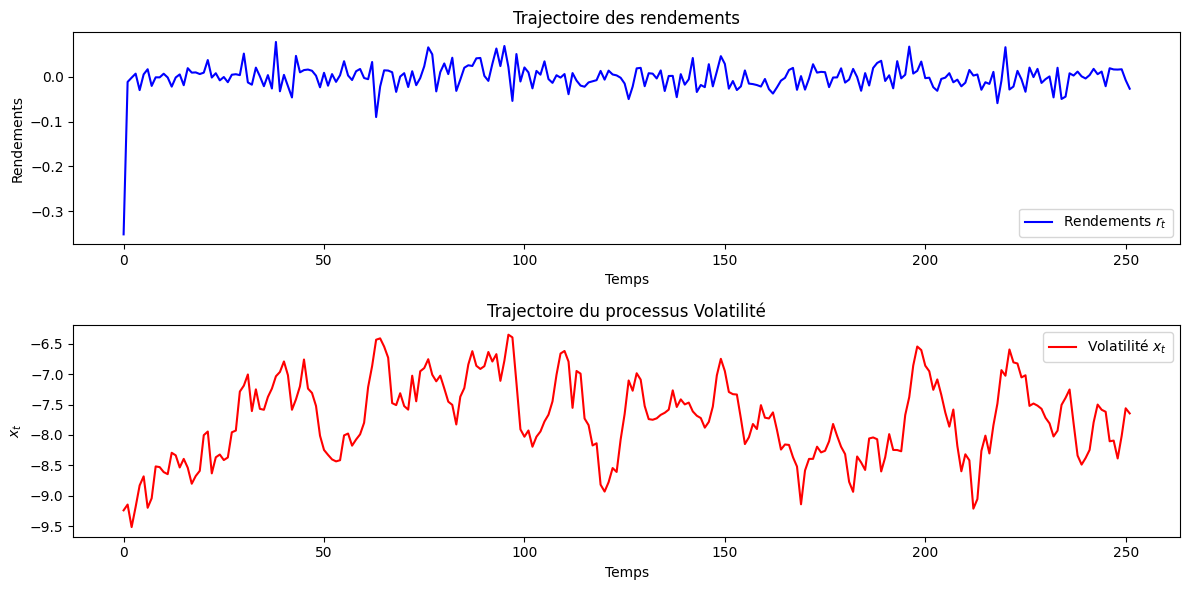

In [ ]:
# Graphique des trajectoires
plt.figure(figsize=(12, 6))

# Graphique des rendements
plt.subplot(2, 1, 1)
plt.plot(r_t, color="blue", label="Rendements $r_t$")
plt.title("Trajectoire des rendements")
plt.xlabel("Temps")
plt.ylabel("Rendements")
plt.legend()

# Graphique du processus log-volatilité
plt.subplot(2, 1, 2)
plt.plot(x_t, color="red", label="Volatilité $x_t$")
plt.title("Trajectoire du processus Volatilité")
plt.xlabel("Temps")
plt.ylabel("$x_t$")
plt.legend()

plt.tight_layout()
plt.show()


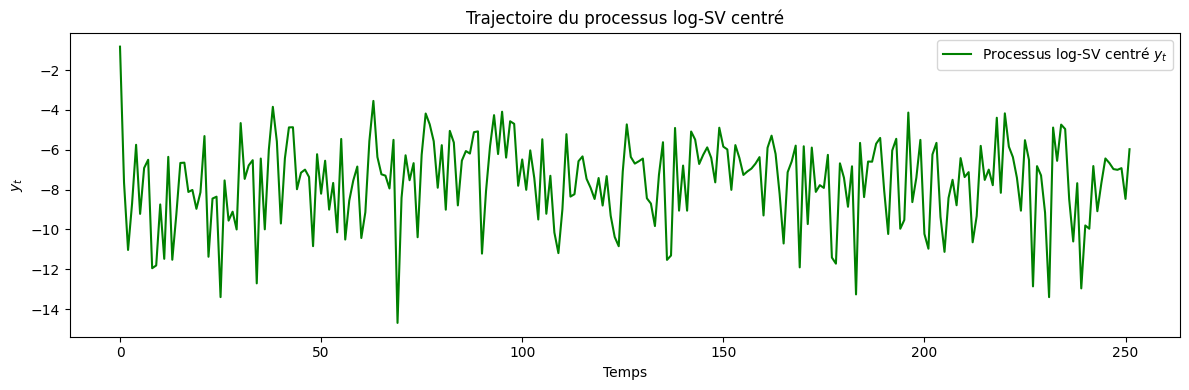

In [ ]:
# Calcul du log du carré des rendements centré
#expected_log_eps2 = np.mean(np.log(eps_t**2))  # Estimation de E[log(eps^2)]
y_t = np.log(r_t**2) + 1.27

# Graphique des trajectoires
plt.figure(figsize=(12, 4))
plt.plot(y_t, color="green", label="Processus log-SV centré $y_t$")
plt.title("Trajectoire du processus log-SV centré")
plt.xlabel("Temps")
plt.ylabel("$y_t$")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Filtre de Kalman

expected_log_eps2 = -1.27
var_log_eps2 = (np.pi**2) / 2

# Initialisation du filtre de Kalman
x_hat = np.zeros(n) # Estimation de x_t
P = np.zeros(n)      # Variance de l'erreur de prédiction

# Conditions initiales
x_hat[0] = mu / (1 - phi)
P[0] = sigma2 / (1 - phi**2)

# Filtre de Kalman
for t in range(1, n):
    # Étape de prédiction
    x_hat_pred = mu + phi * x_hat[t-1]
    P_pred = phi**2 * P[t-1] + sigma2
    y_hat_pred = x_hat_pred

    # Étape de mise à jour
    K_t = P_pred / (P_pred + var_log_eps2)
    x_hat[t] = x_hat_pred + K_t * (y_t[t] - y_hat_pred)
    P[t] = (1 - K_t) * P_pred


# Algorithme MCMC pour estimer la log-volatilité
iterations = 5000
burn_in = 1000
x_samples = np.zeros((iterations, n))

# Initialisation
x_current = np.zeros(n)
x_current[0] = mu / (1 - phi)

# MCMC sampling
for it in range(iterations):
    for t in range(1, n):
        # Proposer un nouvel état
        x_proposed = np.random.normal(mu + phi * x_current[t-1], sigma)

        log_likelihood_current = -0.5 * ((y_t[t] - x_current[t])**2) / (np.pi**2 / 2)
        log_likelihood_proposed = -0.5 * ((y_t[t] - x_proposed)**2) / (np.pi**2 / 2)

        # Ratio d'acceptation
        acceptance_ratio = np.exp(log_likelihood_proposed - log_likelihood_current)

        # Acceptation ou rejet
        if np.random.uniform(0, 1) < acceptance_ratio:
            x_current[t] = x_proposed

    x_samples[it] = x_current

# Moyenne des échantillons après burn-in
x_hat_mcmc = np.mean(x_samples[burn_in:], axis=0)

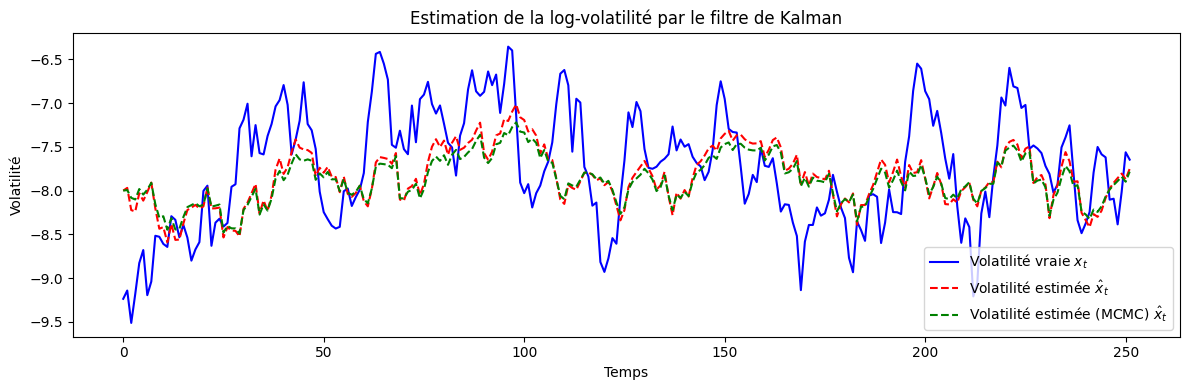

In [ ]:
# Graphique des estimations
plt.figure(figsize=(12, 4))

# Log-volatilité réelle vs estimée
plt.plot(x_t, label="Volatilité vraie $x_t$", color="blue")
plt.plot(x_hat, label="Volatilité estimée $\hat{x}_t$", color="red", linestyle="--")
plt.plot(x_hat_mcmc, label="Volatilité estimée (MCMC) $\hat{x}_t$", color="green", linestyle="--")
plt.title("Estimation de la log-volatilité par le filtre de Kalman")
plt.xlabel("Temps")
plt.ylabel("Volatilité")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Maintenant on suppose Theta0 non connu

# Fonction pour le filtre de Kalman
def kalman_filter(y_t, theta):
    mu, phi, sigma2 = theta
    sigma = np.sqrt(sigma2)
    n = len(y_t)
    var_log_eps2 = (np.pi**2) / 2

    x_hat = np.zeros(n)
    P = np.zeros(n)

    # Conditions initiales
    x_hat[0] = mu / (1 - phi)
    P[0] = sigma2 / (1 - phi**2)

    v_t = np.zeros(n)
    F_t = np.zeros(n)
    rap_t = np.zeros(n)
    for t in range(1, n):
        # Étape de prédiction
        x_hat_pred = mu + phi * x_hat[t-1]
        P_pred = phi**2 * P[t-1] + sigma2
        y_hat_pred = x_hat_pred

        # Innovation et variance de l'innovation
        v_t[t] = y_t[t] - y_hat_pred
        F_t[t] = P_pred + var_log_eps2
        rap_t[t] = (v_t[t]**2) / F_t[t]
        # Mise à jour
        K_t = P_pred / F_t[t]
        x_hat[t] = x_hat_pred + K_t * v_t[t]
        P[t] = (1 - K_t) * P_pred

    return v_t[1:], F_t[1:], rap_t[1:]  # On peut ignorer t=0 car pas de données pour l'innovation

# Fonction de log-vraisemblance quasi maximale
def qml_log_likelihood(theta, y_t):
    v_t, F_t, rap_t = kalman_filter(y_t, theta)
    #print(F_t)
    n = len(v_t)
    log_likelihood = -(n / 2) * np.log(2 * np.pi) - 0.5 * np.sum(np.log(F_t)) - 0.5 * np.sum(rap_t)
    return -log_likelihood  # On minimise donc on retourne l'opposé

# Estimation par quasi-maximum de vraisemblance
def estimate_theta_qml(y_t, initial_guess):
    result = minimize(qml_log_likelihood, initial_guess, args=(y_t,), method='SLSQP', bounds=[(-2, 0), (0, 0.99), (0.01, 0.5)]) #SLSQP
    return result.x, result.success

In [ ]:
# Estimation
initial_guess = [-0.5, 0.5, 0.1]
estimated_theta, success = estimate_theta_qml(y_t, initial_guess)

if success:
    print(f"Estimation réussie : mu = {estimated_theta[0]:.4f}, phi = {estimated_theta[1]:.4f}, sigma2 = {estimated_theta[2]:.4f}")
else:
    print("L'estimation a échoué.")

Estimation réussie : mu = -0.6511, phi = 0.9147, sigma2 = 0.0268


### Estimation du modèle non linéaire SV de Taylor par ﬁltrage particulaire

In [ ]:
from sklearn.utils import resample
from scipy.stats import rv_discrete

In [ ]:
from __future__ import print_function, division

In [ ]:
##############################################################################
# State estimation in LGSS and SV models using Kalman and particle filters
#
# Johan Dahlin <liu (at) johandahlin.com.nospam>
# Documentation at https://github.com/compops/pmh-tutorial
# Published under GNU General Public License
##############################################################################

from __future__ import print_function, division
import numpy as np
from numpy.random import randn, choice
from scipy.stats import norm

##############################################################################
# Kalman filter for the linear Gaussian SSM
##############################################################################
def kalmanFilter(observations, parameters, initialState, initialStateCov):

    noObservations = len(observations)
    A = parameters[0]
    C = 1
    Q = parameters[1]**2
    R = parameters[2]**2

    predictiveCov = initialStateCov
    xHatPredicted = initialState * np.ones((noObservations + 1, 1))
    xHatFiltered = initialState * np.ones((noObservations, 1))

    for t in range(0, noObservations):
        # Correction step
        S = C * predictiveCov * C + R
        kalmanGain = predictiveCov * C / S
        filteredCovariance = predictiveCov - kalmanGain * S * kalmanGain
        yHatPredicted = C * xHatPredicted[t]
        xHatFiltered[t] = xHatPredicted[t] + kalmanGain * (observations[t - 1] - yHatPredicted)

        # Prediction step
        xHatPredicted[t + 1] = A * xHatFiltered[t]
        predictiveCov = A * filteredCovariance * A + Q

    return xHatFiltered

##############################################################################
# Fully-adapted particle filter for the linear Gaussian SSM
##############################################################################
def particleFilter(observations, parameters, noParticles, initialState):

    noObservations = len(observations) - 1
    phi = parameters[0]
    sigmav = parameters[1]
    sigmae = parameters[2]

    particles = np.zeros((noParticles, noObservations))
    ancestorIndices = np.zeros((noParticles, noObservations))
    weights = np.zeros((noParticles, noObservations))
    normalisedWeights = np.zeros((noParticles, noObservations))
    xHatFiltered = np.zeros((noObservations, 1))

    # Set the initial state and weights
    ancestorIndices[: , 0] = range(noParticles)
    particles[:, 0] = initialState
    xHatFiltered[0] = initialState
    normalisedWeights[:, 0] = 1.0 / noParticles
    logLikelihood = 0

    for t in range(1, noObservations):
        # Resample (multinomial)
        newAncestors = choice(noParticles, noParticles, p=normalisedWeights[:, t - 1], replace=True)
        ancestorIndices[:, 1:t - 1] = ancestorIndices[newAncestors, 1:t - 1]
        ancestorIndices[:, t] = newAncestors

        # Propagate
        part1 = (sigmav**(-2) + sigmae**(-2))**(-1)
        part2 = sigmae**(-2) * observations[t]
        part2 = part2 + sigmav**(-2) * phi * particles[newAncestors, t - 1]
        particles[:, t] = part1 * part2 + np.sqrt(part1) * randn(1, noParticles)

        # Compute weights
        yhatMean = phi * particles[:, t]
        yhatVariance = np.sqrt(sigmav**2 + sigmae**2)
        weights[:, t] = norm.logpdf(observations[t + 1], yhatMean, yhatVariance)

        maxWeight = np.max(weights[:, t])
        weights[:, t] = np.exp(weights[:, t] - maxWeight)
        sumWeights = np.sum(weights[:, t])
        normalisedWeights[:, t] = weights[:, t] / sumWeights

        # Estimate the state
        xHatFiltered[t] = np.sum(normalisedWeights[:, t] * particles[:, t])

        # Estimate log-likelihood
        predictiveLikelihood = maxWeight + np.log(sumWeights) - np.log(noParticles)
        logLikelihood += predictiveLikelihood

    return xHatFiltered, logLikelihood

##############################################################################
# Bootstrap particle filter for the stochastic volatility model
##############################################################################
def particleFilterSVmodel(observations, parameters, noParticles):

    noObservations = len(observations)
    mu = parameters[0]
    phi = parameters[1]
    sigmav = parameters[2]

    particles = np.zeros((noParticles, noObservations))
    ancestorIndices = np.zeros((noParticles, noObservations))
    weights = np.zeros((noParticles, noObservations))
    normalisedWeights = np.zeros((noParticles, noObservations))
    xHatFiltered = np.zeros((noObservations, 1))

    # Set the initial state and weights
    np.random.normal(mu / (1 - phi), np.sqrt(sigma2 / (1 - phi**2)), M)
    particles[:, 0] = mu + sigmav / np.sqrt(1.0 - phi**2) * randn(1, noParticles)
    normalisedWeights[:, 0] = 1.0 / noParticles
    weights[:, 0] = 1.0
    logLikelihood = 0

    for t in range(1, noObservations):
        # Resample particles
        newAncestors = choice(noParticles, noParticles, p=normalisedWeights[:, t - 1], replace=True)
        ancestorIndices[:, 1:t - 1] = ancestorIndices[newAncestors, 1:t - 1]
        ancestorIndices[:, t] = newAncestors

        # Propagate particles
        particles[:, t] = mu + phi * (particles[newAncestors, t - 1] - mu) + sigmav * randn(1, noParticles)

        # Weight particles
        weights[:, t] = norm.logpdf(observations[t - 1], 0, np.exp(particles[:, t] / 2))

        maxWeight = np.max(weights[:, t])
        weights[:, t] = np.exp(weights[:, t] - maxWeight)
        sumWeights = np.sum(weights[:, t])
        normalisedWeights[:, t] = weights[:, t] / sumWeights

        # Estimate the filtered state
        xHatFiltered[t] = np.sum(normalisedWeights[:, t] * particles[:, t])

        # Estimate log-likelihood
        predictiveLikelihood = maxWeight + np.log(sumWeights) - np.log(noParticles)
        logLikelihood += predictiveLikelihood


    # Sample the state estimate using the weights at t=T
    ancestorIndex = choice(noParticles, 1, p=normalisedWeights[:, noObservations - 1])
    stateTrajectory = particles[ancestorIndices[ancestorIndex, noObservations - 1].astype(int), :]

    return stateTrajectory.ravel(), logLikelihood

In [ ]:
# Initialisation des processus
x_t = np.random.normal(((mu-phi*mu)/(1-phi)), ((sigma2/(1-phi**2))**0.5), n)
r_t = np.random.normal(0, 1, n)

# Simulation des chocs iid
nu_t = np.random.normal(0, 1, n)
eps_t = np.random.normal(0, 1, n)

# Simulation du processus log-volatilité x_t et des rendements r_t
for t in range(1, n):
    x_t[t] = mu + phi * (x_t[t-1] - mu) + sigma * nu_t[t]
    r_t[t] = np.exp(x_t[t] / 2) * eps_t[t]

In [ ]:
trajectoire, log_likelihood = particleFilterSVmodel(r_t, [mu, phi, sigma], 1000)

In [ ]:
# Bootstrap Particle Filter

def bootstrap_filter(r_t, M, mu, phi, sigma, n):
    # Initialisation
    x_hat = np.zeros(n)  # Estimation de x_t
    particles = np.random.normal(mu, sigma, M)  # Initialisation des particules
    weights = np.ones(M) / M  # Poids initiaux des particules

    for t in range(n):
        # Prédiction : échantillonner xti à partir de p(xt|xti−1)
        particles = mu + phi * (particles - mu) + sigma * np.random.normal(0, 1, M)

        # Mise à jour des poids : p(yt|xti)
        likelihood = np.exp(-0.5 * (r_t[t]**2 / np.exp(particles / 2)))
        weights = likelihood

        # Normalisation des poids
        weights /= np.sum(weights)
        # Rééchantillonnage
        resampled_indices = np.random.choice(M, size=M, replace=True, p=weights)

        resampled_particles = particles[resampled_indices] #resample(particles, replace=True, n_samples=M)
        particles = resampled_particles
        x_hat[t] = np.mean(particles)  # Estimation de x_t à l'instant t
        weights = np.ones(M) / M  # Réinitialisation des poids

    return x_hat

# Paramètres pour le filtre Bootstrap
M = 1000  # Nombre de particules
x_hat = bootstrap_filter(r_t, M, mu, phi, sigma, n)

In [ ]:
r_hat = np.exp(x_hat / 2) * np.random.normal(0, 1, n)

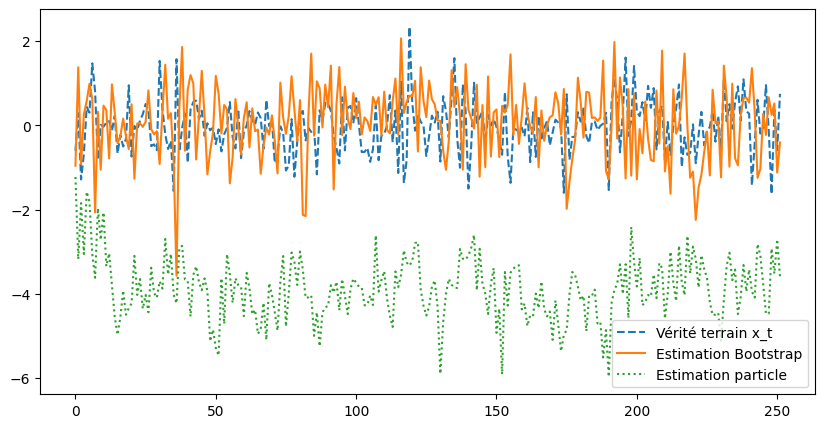

In [ ]:
# Affichage des résultats
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(r_t, label='Vérité terrain x_t', linestyle='dashed')
plt.plot(r_hat, label='Estimation Bootstrap')
plt.plot(trajectoire, label='Estimation particle', linestyle='dotted')
plt.legend()
plt.show()

## TP 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.optimize import broyden1

In [ ]:
# Calcul de prix de Call
def heston(lambda_,v_bar,nu, rho, X0, V0, T, r, K):
    I=complex(0,1)
    P, umax, N = 0, 1000, 10000
    du=umax/N
    aa= v_bar*lambda_*T/nu**2
    bb= -2*v_bar*lambda_/nu**2
    for i in range (1,N) :
         u2=i*du
         u1=complex(u2,-1)
         a1=rho*nu*u1*I
         a2=rho*nu*u2*I
         d1=np.sqrt((a1-lambda_)**2+nu**2*(u1*I+u1**2))
         d2=np.sqrt((a2-lambda_)**2+nu**2*(u2*I+u2**2))
         g1=(lambda_-a1-d1)/(lambda_-a1+d1)
         g2=(lambda_-a2-d2)/(lambda_-a2+d2)
         b1=np.exp(u1*I*(np.log(X0/K)+r*T))*( (1-g1*np.exp(-d1*T))/(1-g1) )**bb
         b2=np.exp(u2*I*(np.log(X0/K)+r*T))*( (1-g2*np.exp(-d2*T))/(1-g2) )**bb
         phi1=b1*np.exp(aa*(lambda_-a1-d1)\
            +V0*(lambda_-a1-d1)*(1-np.exp(-d1*T))/(1-g1*np.exp(-d1*T))/nu**2)
         phi2=b2*np.exp(aa*(lambda_-a2-d2)\
            +V0*(lambda_-a2-d2)*(1-np.exp(-d2*T))/(1-g2*np.exp(-d2*T))/nu**2)
         P+= ((phi1-phi2)/(u2*I))*du
    return K*np.real((X0/K-np.exp(-r*T))/2+P/np.pi)

In [ ]:
X0 = 100
V0 = 0.03
r = 0.05
lambda_ = 4
v_bar=0.03
nu=0.4
rho=-0.5

# Example of usage of heston()
T,K=1,100
call = heston(lambda_,v_bar,nu, rho, X0, V0, T, r, K)
print("call = ",call, " put = ", call-X0+K*np.exp(-r*T))

call =  9.71572505209945  put =  4.83866750217085


In [ ]:
def heston_monte_carlo(X0, V0, r, lambda_, v_bar, nu, rho, T, K, N=10000, M=1000):
    dt = T / M
    S = np.zeros((N, M+1))
    V = np.zeros((N, M+1))
    S[:, 0] = X0
    V[:, 0] = V0

    for t in range(1, M+1):
        Z1 = np.random.normal(0, 1, N)
        Z2 = np.random.normal(0, 1, N)
        Z = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        V[:, t] = np.maximum(V[:, t-1] + lambda_ * (v_bar - V[:, t-1]) * dt + nu * np.sqrt(V[:, t-1]) * np.sqrt(dt) * Z1, 0)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * V[:, t-1]) * dt + np.sqrt(V[:, t-1]) * np.sqrt(dt) * Z)

    payoff = np.maximum(S[:, -1] - K, 0)
    call_price = np.exp(-r * T) * np.mean(payoff)

    return call_price

N = 100000  # Nombre de simulations
M = 1000   # Nombre de pas de temps

call_price = heston_monte_carlo(X0, V0, r, lambda_, v_bar, nu, rho, T, K, N, M)
print(f"Prix de l'option call par Monte Carlo: {call_price:.2f}")

Prix de l'option call par Monte Carlo: 9.404192540128252


In [ ]:
# Calibration du modèle d’Heston
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du modèle
lambda_ = 4       # Taux de retour à la moyenne de la volatilité
eta = 0.4         # Volatilité de la volatilité
v_bar = 0.03      # Volatilité moyenne à long terme
rho = -0.5        # Corrélation entre les mouvements du sous-jacent et de la volatilité
sigma_epsilon = np.sqrt(0.1)  # Écart-type du bruit de mesure
K = 100           # Strike de l'option
tau = 1           # Maturité de l'option
r = 0.05          # Taux d'intérêt sans risque
T = 1             # Durée totale de l'observation
n = 252           # Nombre de jours (points d'observation)
dt = T / n        # Pas de temps

# Nombre de particules
M = 1000

# Fonction pour simuler le modèle de Heston
def heston_simulate(S0, v0, r, lambda_, v_bar, eta, rho, T, n):
    dt = T / n
    S = np.zeros(n + 1)
    v = np.zeros(n + 1)
    S[0] = S0
    v[0] = v0

    for t in range(1, n + 1):
        Z1 = np.random.normal(0, 1)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1)

        v[t] = np.abs(v[t - 1] + lambda_ * (v_bar - v[t - 1]) * dt + eta * np.sqrt(v[t - 1]) * np.sqrt(dt) * Z2)
        S[t] = S[t - 1] * (1 + r * dt + np.sqrt(v[t - 1]) * np.sqrt(dt) * Z1)

    return S, v

# Fonction pour calculer le prix d'un Call sous Heston (approximation)
def heston_call_price(S, v, K, r, tau):
    d1 = (np.log(S / K) + (r + 0.5 * v) * tau) / (np.sqrt(v) * np.sqrt(tau))
    d2 = d1 - np.sqrt(v) * np.sqrt(tau)
    call_price = S * 0.5 * (1 + np.erf(d1 / np.sqrt(2))) - K * np.exp(-r * tau) * 0.5 * (1 + np.erf(d2 / np.sqrt(2)))
    return call_price

# Génération des données observées (simulées)
np.random.seed(42)
S0 = 100
v0 = 0.03
S_true, v_true = heston_simulate(S0, v0, r, lambda_, v_bar, eta, rho, T, n)
y_true = np.array([heston_call_price(S_true[t], v_true[t], K, r, tau) for t in range(n + 1)])
y_observed = y_true + np.random.normal(0, sigma_epsilon, n + 1)  # Ajout de bruit de mesure

# Filtre à particules
def bootstrap_particle_filter(y_observed, S0, v0, r, lambda_, v_bar, eta, rho, T, n, M):
    dt = T / n
    v_particles = np.zeros((M, n + 1))
    weights = np.zeros((M, n + 1))
    v_particles[:, 0] = v0  # Initialisation des particules
    weights[:, 0] = 1 / M   # Poids initiaux uniformes

    for t in range(1, n + 1):
        for i in range(M):
            # Étape de prédiction : simuler v_t à partir de v_{t-1}
            Z2 = np.random.normal(0, 1)
            v_particles[i, t] = np.abs(v_particles[i, t - 1] + lambda_ * (v_bar - v_particles[i, t - 1]) * dt + eta * np.sqrt(v_particles[i, t - 1]) * np.sqrt(dt) * Z2)

            # Étape de mise à jour des poids
            S_t = S_true[t - 1] * (1 + r * dt + np.sqrt(v_particles[i, t - 1]) * np.sqrt(dt) * np.random.normal(0, 1))
            y_pred = heston_call_price(S_t, v_particles[i, t], K, r, tau)
            weights[i, t] = np.exp(-0.5 * (y_observed[t] - y_pred)**2 / sigma_epsilon**2)

        # Normalisation des poids
        weights[:, t] /= np.sum(weights[:, t])

        # Étape de rééchantillonnage
        indices = np.random.choice(M, M, p=weights[:, t])
        v_particles[:, t] = v_particles[indices, t]
        weights[:, t] = 1 / M  # Réinitialisation des poids

    # Estimation de la trajectoire de v_t
    v_estimated = np.mean(v_particles, axis=0)
    return v_estimated

# Application du filtre à particules
v_estimated = bootstrap_particle_filter(y_observed, S0, v0, r, lambda_, v_bar, eta, rho, T, n, M)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n + 1) * dt, v_true, label="Volatilité réelle", color="blue")
plt.plot(np.arange(n + 1) * dt, v_estimated, label="Volatilité estimée", color="red", linestyle="--")
plt.xlabel("Temps")
plt.ylabel("Volatilité")
plt.title("Estimation de la volatilité par filtre à particules")
plt.legend()
plt.grid()
plt.show()

AttributeError: module 'numpy' has no attribute 'erf'